In this project, we will design an algorithm to most efficiently predict which team in the National Basketball Association (NBA) will win the championship. Along with this, our algorithm will be able to identify and select specific players who are upcoming free agents (players with no contract with any team), and match them to a team who needs their skillset the most. In other words, our algorithm will select available players to join a team to maximize that team's chance to win a championship, based on its belief of what makes a team most likely to win a championship. To determine what teams have the best chance of winning a championship, we will use specific team data that historically correlates to championships. Specifically, we will use data like ORTG (Offensive Rating), where the higher the rating, the better the team's offense, and DRTG (Defensive Rating), where the lower the rating, the better the team’s defense. For example, last year, the Boston Celtics won the NBA championship. The Celtics ranked 1st in ORTG (123.2) and 3rd in DRTG (111.6) of all thirty NBA teams. In fact, the Celtics were the only NBA team to be top 3 in both. Other data that may be helpful to determine the NBA team most likely to win a championship is TS% (True shooting percentage [A players averaged shooting percentage between 2 point shots, 3 point shots, and 1 point shots]), which the Celtics also ranked 1st in. Average team age may be helpful as well, as only one team in NBA history has won a championship with an average age of 26.5 or below (age calculated by [sum of age * minutes] / [ sum of minutes]). Similarly, for determining what player (that is a free agent) best optimizes a team to win a championship, we will use the same data, but at an individual level. (ORTG, DRTG, TS%, Age) all exist as individual stats for players as well. Thus, if a team has a top DRTG, but lacks in ORTG, our algorithm will likely assign a player with a high ORTG to join that team, to maximize their chance of winning a championship. 

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
#The data for the players for one season
def player_Seasonal_Data(yr):
    """ Gets the seasonal data for all players for a specific season

    Args:
        yr (int): The year in which we want the table

    Returns:
        players_df (df): the dataframe containing all the player data for that year  
    """
    url = f"https://www.basketball-reference.com/leagues/NBA_{yr}_per_game.html"
    players_df = pd.read_html(url)[0].iloc[:-1,1:]
    return players_df

p_df = player_Seasonal_Data(2024)
p_df

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards
0,Joel Embiid,29.0,PHI,C,39.0,39.0,33.6,11.5,21.8,0.529,...,2.4,8.6,11.0,5.6,1.2,1.7,3.8,2.9,34.7,AS
1,Luka Dončić,24.0,DAL,PG,70.0,70.0,37.5,11.5,23.6,0.487,...,0.8,8.4,9.2,9.8,1.4,0.5,4.0,2.1,33.9,"MVP-3,CPOY-6,AS,NBA1"
2,Giannis Antetokounmpo,29.0,MIL,PF,73.0,73.0,35.2,11.5,18.8,0.611,...,2.7,8.8,11.5,6.5,1.2,1.1,3.4,2.9,30.4,"MVP-4,DPOY-9,CPOY-12,AS,NBA1"
3,Shai Gilgeous-Alexander,25.0,OKC,PG,75.0,75.0,34.0,10.6,19.8,0.535,...,0.9,4.7,5.5,6.2,2.0,0.9,2.2,2.5,30.1,"MVP-2,DPOY-7,CPOY-3,AS,NBA1"
4,Jalen Brunson,27.0,NYK,PG,77.0,77.0,35.4,10.3,21.4,0.479,...,0.6,3.1,3.6,6.7,0.9,0.2,2.4,1.9,28.7,"MVP-5,CPOY-5,AS,NBA2"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,Danny Green,36.0,PHI,SG,2.0,0.0,9.0,0.0,1.0,0.000,...,0.0,1.0,1.0,0.5,0.5,0.0,0.0,0.5,0.0,NaN
731,Ron Harper Jr.,23.0,TOR,PF,1.0,0.0,4.0,0.0,0.0,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,NaN
732,Justin Jackson,28.0,MIN,SF,2.0,0.0,0.5,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
733,Dmytro Skapintsev,25.0,NYK,C,2.0,0.0,1.0,0.0,0.5,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [3]:
#Cleans the player data
def clean_Player_Data(players_df):
    """ Cleans the data for a players for a specific season (seperates awards)

    Args:
        players_df (df): the dirty player dataframe

    Returns:
        clean_df (df): the cleaned player dataframe
    """


    award_list = ['AS','6MOY','NBA','CPOY','DPOY','MVP','MIP','ROY'] 
    awards_df = pd.DataFrame(columns=award_list)

    #Loop through award column
    for awards in players_df['Awards']:
        a_row = [0,0,0,0,0,0,0,0]

        #if there is no value fill in with 0s
        if(type(awards) == float):
            awards_df.loc[len(awards_df)] = a_row
        else:
            a = awards.split(',')
            #loop through individual awards
            for award in a:
                if 'AS' in award:
                    a_row[0] = 1
                elif '6MOY' in award:
                    a_row[1] = award.split('-')[1]
                elif 'NBA' in award:
                    a_row[2] = award[-1:]
                elif 'CPOY' in award:
                    a_row[3] = award.split('-')[1]
                elif 'DPOY' in award:
                    a_row[4] = award.split('-')[1]
                elif 'MVP' in award:
                    a_row[5] = award.split('-')[1]
                elif 'MIP' in award:
                    a_row[6] = award.split('-')[1]
                elif 'ROY' in award:
                    a_row[7] = award.split('-')[1]
        
            awards_df.loc[len(awards_df)] = a_row
        
    clean_df =  pd.concat([players_df.iloc[:,:-1], awards_df], axis=1)   
    return clean_df

clean_player_df = clean_Player_Data(p_df)
clean_player_df

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,PF,PTS,AS,6MOY,NBA,CPOY,DPOY,MVP,MIP,ROY
0,Joel Embiid,29.0,PHI,C,39.0,39.0,33.6,11.5,21.8,0.529,...,2.9,34.7,1,0,0,0,0,0,0,0
1,Luka Dončić,24.0,DAL,PG,70.0,70.0,37.5,11.5,23.6,0.487,...,2.1,33.9,1,0,1,6,0,3,0,0
2,Giannis Antetokounmpo,29.0,MIL,PF,73.0,73.0,35.2,11.5,18.8,0.611,...,2.9,30.4,1,0,1,12,9,4,0,0
3,Shai Gilgeous-Alexander,25.0,OKC,PG,75.0,75.0,34.0,10.6,19.8,0.535,...,2.5,30.1,1,0,1,3,7,2,0,0
4,Jalen Brunson,27.0,NYK,PG,77.0,77.0,35.4,10.3,21.4,0.479,...,1.9,28.7,1,0,2,5,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,Danny Green,36.0,PHI,SG,2.0,0.0,9.0,0.0,1.0,0.000,...,0.5,0.0,0,0,0,0,0,0,0,0
731,Ron Harper Jr.,23.0,TOR,PF,1.0,0.0,4.0,0.0,0.0,NaN,...,2.0,0.0,0,0,0,0,0,0,0,0
732,Justin Jackson,28.0,MIN,SF,2.0,0.0,0.5,0.0,0.0,NaN,...,0.0,0.0,0,0,0,0,0,0,0,0
733,Dmytro Skapintsev,25.0,NYK,C,2.0,0.0,1.0,0.0,0.5,0.000,...,0.0,0.0,0,0,0,0,0,0,0,0


In [4]:
#The data for the teams
def get_seasonal_team_data(yr):
    """ Gets the team data for all teams for a specific season
    
    Args:
        yr (int): THe year in which we will be collecting data

    Returns:
        team_df (df): the team data for that season
    """
    url = f'https://www.basketball-reference.com/leagues/NBA_{yr}.html'
    team_df = pd.read_html(url, header=1, index_col=False)[10].iloc[:,1:]
    #add year to data
    year = [yr] * 31
    team_df.insert(0,'Year', year)
    return team_df
    
team_df = get_seasonal_team_data(2024)
team_df

,Year,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,FT/FGA,Unnamed: 22,eFG%.1,TOV%.1,DRB%,FT/FGA.1,Unnamed: 27,Arena,Attend.,Attend./G
0,2024,Boston Celtics*,28.2,64.0,18.0,66,16,11.34,-0.60,10.75,...,0.180,NaN,0.523,10.8,76.3,0.145,NaN,TD Garden,785396,19156
1,2024,Oklahoma City Thunder*,23.4,57.0,25.0,58,24,7.41,-0.05,7.36,...,0.198,NaN,0.530,13.6,73.8,0.202,NaN,Paycom Center,715509,17451
2,2024,Minnesota Timberwolves*,27.2,56.0,26.0,57,25,6.45,-0.07,6.39,...,0.209,NaN,0.515,12.9,76.9,0.197,NaN,Target Center,720960,17584
3,2024,Denver Nuggets*,27.1,57.0,25.0,54,28,5.26,-0.03,5.23,...,0.170,NaN,0.526,11.2,75.6,0.195,NaN,Ball Arena,807062,19684
4,2024,New York Knicks*,26.4,50.0,32.0,53,29,4.59,-0.23,4.36,...,0.192,NaN,0.543,12.3,76.1,0.176,NaN,Madison Square Garden (IV),808885,19729
5,2024,New Orleans Pelicans*,26.0,49.0,33.0,52,30,4.41,0.05,4.46,...,0.202,NaN,0.541,12.9,76.9,0.186,NaN,Smoothie King Center,692054,17301
6,2024,Los Angeles Clippers*,30.4,51.0,31.0,49,33,3.28,0.13,3.41,...,0.211,NaN,0.541,11.7,74.8,0.183,NaN,Crypto.com Arena,776782,18946
7,2024,Philadelphia 76ers*,28.4,47.0,35.0,49,33,3.05,-0.54,2.51,...,0.218,NaN,0.537,13.1,74.3,0.215,NaN,Wells Fargo Center,821714,20042
8,2024,Phoenix Suns*,29.3,49.0,33.0,49,33,3.06,0.02,3.08,...,0.219,NaN,0.536,11.3,75.6,0.178,NaN,Footprint Center,699911,17071
9,2024,Indiana Pacers*,25.3,47.0,35.0,48,34,3.05,-0.30,2.75,...,0.173,NaN,0.556,12.1,74.1,0.228,NaN,Gainbridge Fieldhouse,677554,16526


In [5]:
#clean the team data
def clean_team_data(team_df):
    """ Cleans a seasonal team dataframe
    
    Args:
        team_df (df): The team dataframe we will be cleaning

    Returns:
        clean_df (df): the cleaned team dataframe
    """
    # get rid of random columns
    for series_name, series in team_df.items():
        if "Unnamed" in series_name:
            del team_df[series_name]

    #remove unimportant data
    clean_df = team_df.iloc[:-1,:-3]


    #remove * in team names
    clean_df['Team'] = clean_df['Team'].str.replace('*', '', regex=False)
        

    #Abbrieviate team names
    team_abbreviations = {
        'Atlanta Hawks': 'ATL',
        'Boston Celtics': 'BOS',
        'Brooklyn Nets': 'BKN',
        'Charlotte Hornets': 'CHA',
        'Chicago Bulls': 'CHI',
        'Cleveland Cavaliers': 'CLE',
        'Dallas Mavericks': 'DAL',
        'Denver Nuggets': 'DEN',
        'Detroit Pistons': 'DET',
        'Golden State Warriors': 'GSW',
        'Houston Rockets': 'HOU',
        'Indiana Pacers': 'IND',
        'Los Angeles Clippers': 'LAC',
        'Los Angeles Lakers': 'LAL',
        'Memphis Grizzlies': 'MEM',
        'Miami Heat': 'MIA',
        'Milwaukee Bucks': 'MIL',
        'Minnesota Timberwolves': 'MIN',
        'New Orleans Pelicans': 'NOP',
        'New York Knicks': 'NYK',
        'Oklahoma City Thunder': 'OKC',
        'Orlando Magic': 'ORL',
        'Philadelphia 76ers': 'PHI',
        'Phoenix Suns': 'PHX',
        'Portland Trail Blazers': 'POR',
        'Sacramento Kings': 'SAC',
        'San Antonio Spurs': 'SAS',
        'Toronto Raptors': 'TOR',
        'Utah Jazz': 'UTA',
        'Washington Wizards': 'WAS'
    }

    clean_df['Team'] = clean_df['Team'].replace(team_abbreviations)

    return clean_df

clean_df = clean_team_data(team_df)
clean_df


,Year,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1
0,2024,BOS,28.2,64.0,18.0,66,16,11.34,-0.60,10.75,...,0.471,0.609,0.578,10.8,24.9,0.180,0.523,10.8,76.3,0.145
1,2024,OKC,23.4,57.0,25.0,58,24,7.41,-0.05,7.36,...,0.383,0.608,0.573,11.4,21.1,0.198,0.530,13.6,73.8,0.202
2,2024,MIN,27.2,56.0,26.0,57,25,6.45,-0.07,6.39,...,0.384,0.594,0.559,13.0,23.2,0.209,0.515,12.9,76.9,0.197
3,2024,DEN,27.1,57.0,25.0,54,28,5.26,-0.03,5.23,...,0.352,0.589,0.562,11.5,25.5,0.170,0.526,11.2,75.6,0.195
4,2024,NYK,26.4,50.0,32.0,53,29,4.59,-0.23,4.36,...,0.404,0.574,0.540,11.9,29.4,0.192,0.543,12.3,76.1,0.176
5,2024,NOP,26.0,49.0,33.0,52,30,4.41,0.05,4.46,...,0.373,0.591,0.558,11.8,24.4,0.202,0.541,12.9,76.9,0.186
6,2024,LAC,30.4,51.0,31.0,49,33,3.28,0.13,3.41,...,0.383,0.599,0.561,12.0,24.4,0.211,0.541,11.7,74.8,0.183
7,2024,PHI,28.4,47.0,35.0,49,33,3.05,-0.54,2.51,...,0.373,0.574,0.532,10.7,24.8,0.218,0.537,13.1,74.3,0.215
8,2024,PHX,29.3,49.0,33.0,49,33,3.06,0.02,3.08,...,0.378,0.603,0.565,13.4,25.0,0.219,0.536,11.3,75.6,0.178
9,2024,IND,25.3,47.0,35.0,48,34,3.05,-0.30,2.75,...,0.380,0.606,0.578,11.3,23.8,0.173,0.556,12.1,74.1,0.228


In [6]:
def all_time_data():
    """ Gets team data for all years (1947-2024)

    Returns:
        historical_df (df): historical team data
    """
    historical_df = pd.DataFrame()

    for yr in range(2024,2015,-1):
        year_df = clean_team_data(get_seasonal_team_data(yr))
        historical_df = pd.concat([historical_df,year_df])

    return historical_df

df = all_time_data()
df


,Year,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1
0,2024,BOS,28.2,64.0,18.0,66,16,11.34,-0.60,10.75,...,0.471,0.609,0.578,10.8,24.9,0.180,0.523,10.8,76.3,0.145
1,2024,OKC,23.4,57.0,25.0,58,24,7.41,-0.05,7.36,...,0.383,0.608,0.573,11.4,21.1,0.198,0.530,13.6,73.8,0.202
2,2024,MIN,27.2,56.0,26.0,57,25,6.45,-0.07,6.39,...,0.384,0.594,0.559,13.0,23.2,0.209,0.515,12.9,76.9,0.197
3,2024,DEN,27.1,57.0,25.0,54,28,5.26,-0.03,5.23,...,0.352,0.589,0.562,11.5,25.5,0.170,0.526,11.2,75.6,0.195
4,2024,NYK,26.4,50.0,32.0,53,29,4.59,-0.23,4.36,...,0.404,0.574,0.540,11.9,29.4,0.192,0.543,12.3,76.1,0.176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2016,MIL,23.5,33.0,49.0,29,53,-4.18,0.20,-3.98,...,0.189,0.537,0.499,14.2,24.9,0.207,0.510,14.2,73.1,0.221
26,2016,PHX,26.0,23.0,59.0,24,58,-6.66,0.34,-6.32,...,0.302,0.526,0.487,15.2,25.4,0.204,0.523,13.5,77.1,0.237
27,2016,BKN,26.9,21.0,61.0,22,60,-7.35,0.24,-7.12,...,0.218,0.527,0.492,13.6,24.1,0.186,0.534,13.1,75.7,0.176
28,2016,LAL,26.5,17.0,65.0,17,65,-9.56,0.64,-8.92,...,0.290,0.509,0.460,12.5,23.1,0.228,0.523,11.6,74.7,0.202


In [7]:
## Graphs
import plotly.express as px
import plotly.graph_objects as go

# Gets the FG% and Games played (G) and the player names
fg_percentages_1 = clean_player_df['FG%']
games_played_1 = clean_player_df['G']
player_names_1 = clean_player_df['Player']

# Gets the eFG% and number of Wins and team names
fg_percentages_2 = clean_df['eFG%']
games_played_2 = clean_df['W']
team_names_2 = clean_df['Team']

# Plots the player data
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=fg_percentages_1, 
    y=games_played_1, 
    mode='markers', 
    name='Players',
    marker=dict(color='blue', size=10),
    text=player_names_1,  # Hover data for player names
    hovertemplate='Player: %{text}<br>FG%: %{x}<br>Games Played: %{y}<extra></extra>'
))

# Plots the team data
fig.add_trace(go.Scatter(
    x=fg_percentages_2, 
    y=games_played_2, 
    mode='markers', 
    name='Teams',
    marker=dict(color='red', size=12, symbol='diamond'),
    text=team_names_2,  # Hover data for team names
    hovertemplate='Team: %{text}<br>FG%: %{x}<br>Games Played: %{y}<extra></extra>'
))

# Creates the layout
fig.update_layout(
    title='FG% vs Games Played (Players and Teams)',
    xaxis_title='Field Goal Percentage (FG%)',
    yaxis_title='Games Played (G)',
    legend_title='Data Type',
    height=600,
    width=800
)

# Shows the plot
fig.show()

In [8]:

fig = px.scatter(
    df, 
    x='W', 
    y='L', 
    color='Year',  # Different colors for each year
    hover_name='Team',  # Hover data showing team names
    hover_data={'Year': True, 'W': False, 'L': False},  # Include Year in hover, but hide W and L
    title='Total Wins vs Losses by Team and Year',
    labels={'W': 'Total Wins', 'L': 'Total Losses'}
)


fig.update_layout(
    height=600,
    width=800,
    legend_title='Season Year'
)


fig.show()

In [9]:
#Varaibles we are using to predict
feat_list = ['ORtg', 'DRtg', 'TOV%']

X = pd.DataFrame()
for feat in df.columns:
    if feat in feat_list:
        X[f'{feat}'] = (df[feat] - df[feat].mean()) / df[feat].std()
X = X.values

#get y
y = df['W']

In [10]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

def line_of_best_fit(X,y):
    """Takes in all predictors values X and response values y, returning vector containing coefficients for the line of best Fit
        Args: 
            X (array): 1-d or 2-d array of predictor values
            y (array): 1-d array of all response values to X
            
        Returns:
            coef (array): vector containing coefficients for line of best fit"""
    X = add_bias_column(X)
    XtXinv = np.linalg.inv(np.matmul(X.T, X))
    coef = np.matmul(XtXinv, np.matmul(X.T, y))
    return coef

def linreg_predict(Xnew, ynew, m):
    """Gets predicted values, residuals, mse, and r^2 for a specific input of arrays
    
    Args:
        Xnew (array): array with x values, not including bias terms
        ynew (array): all response values to Xnew
        m (array): coefficients from line of best fit
        
    Retuns:
        linreg_dict (dictionary): dictionary containing ypreds, resids, mse, and r^2"""

    #get ypreds
    ypreds = np.matmul(add_bias_column(Xnew), m)

    #get resids
    resids = ynew - ypreds

    #get mse
    MSE = np.mean(resids ** 2)

    #get r^2
    r2 = r2_score(ynew, ypreds)

    linreg_dict = {'ypreds': ypreds, 'resids': resids, 'mse': MSE, 'r2': r2}

    return linreg_dict

In [11]:
#line of best fit values
m = line_of_best_fit(X,y)

#Linear regression values
pred_values = linreg_predict(X,y, m)
#predicted wins
preds = pred_values['ypreds']
#residuals
resids = pred_values['resids']
#MSE
MSE = pred_values['mse']
print("MSE: " + str(MSE))
#r2
r2 = pred_values['r2']
print("r^2: " + str(r2))

MSE: 14.706841990817946
r^2: 0.8958476288965742


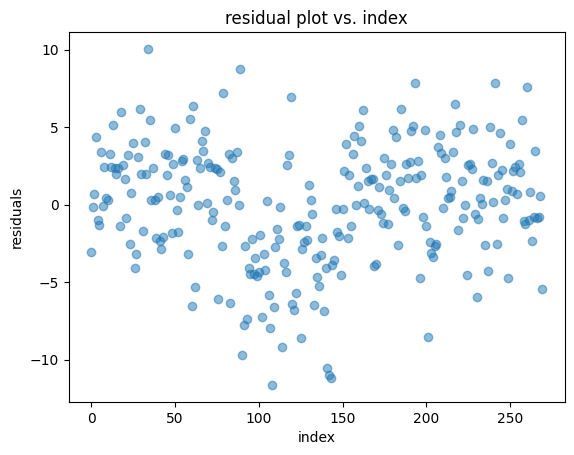

In [12]:
# Residuals v index (independence)
plt.scatter(range(len(X)), resids, alpha=0.5)
plt.xlabel("index")
plt.ylabel("residuals")
plt.title("residual plot vs. index")
plt.show()

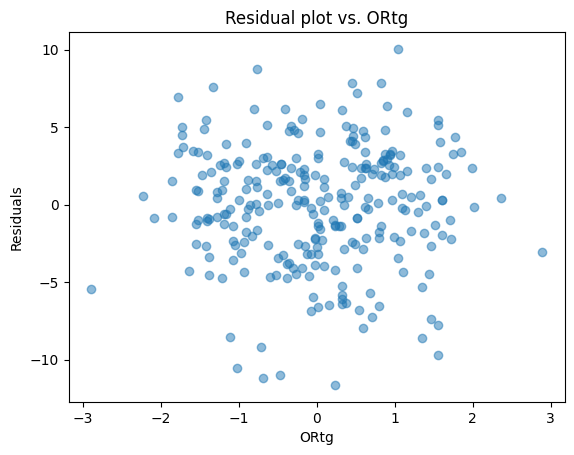

In [13]:
#cylinders vs. residuals (constant variance/linearity)
plt.scatter(X[:,0], resids, alpha=0.5)
plt.xlabel("ORtg")
plt.ylabel("Residuals")
plt.title("Residual plot vs. ORtg")
plt.show()

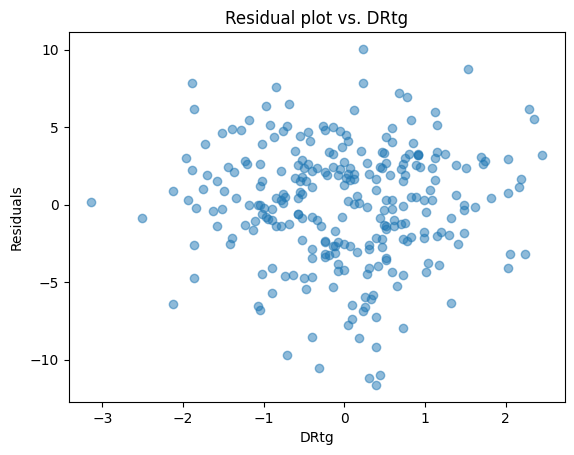

In [14]:
#cylinders vs. residuals (constant variance/linearity)
plt.scatter(X[:,1], resids, alpha=0.5)
plt.xlabel("DRtg")
plt.ylabel("Residuals")
plt.title("Residual plot vs. DRtg")
plt.show()

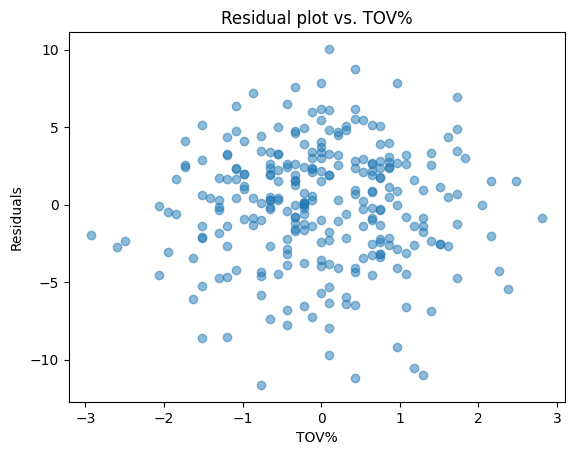

In [15]:
#cylinders vs. residuals (constant variance/linearity)
plt.scatter(X[:,2], resids, alpha=0.5)
plt.xlabel("TOV%")
plt.ylabel("Residuals")
plt.title("Residual plot vs. TOV%")
plt.show()

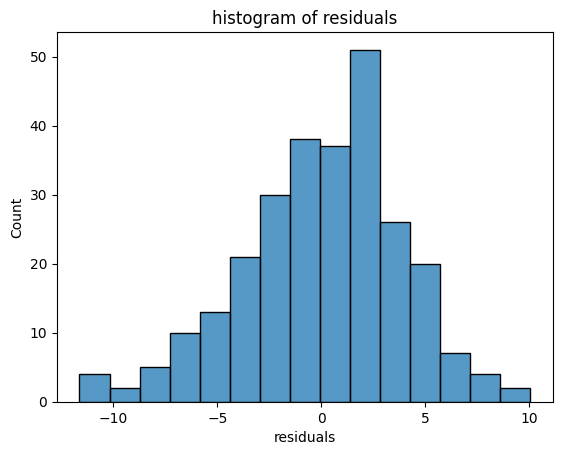

In [16]:
# histogram of residuals (normality)
sns.histplot(resids, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

Looking at our preliminary results, we see that there is clearly an accuracy within predicting the best and worst teams (most and least wins) recently in the NBA. For example, our ML model correctly predicted the 2024 Boston Celtics, who won the championship, to be the best team, and predicted the 2016 Philadelphia 76ers (who had a record of 10 wins to 72 losses) to be the worst team. Furthermore, our ML model generated an R^2 of 0.8958476288965742, showing that our ML model is quite accurate in predicting the actual data. Our R^2 shows that our model performs well in capturing the relationship between the input features (teams offensive rating, defensive rating, and turnover percentage) and the target variable (wins). Our ML model also generated an MSE of 14.706814990817946, which is pretty good as MSE is supposed to be as low as possible. This shows that there is a low variance in errors in our ML model. 

 For ethical considerations, we have generally agreed that there aren’t any besides impact on a players life. In recent times, a common argument against data analytics in sports is that the data doesn’t fully capture all aspects of the sport. While the data can predict outcomes and certainly help with decisions regarding players, they miss out on emotions and family situations that could be occurring with the player. Something that is not really considered when seeing a player get traded or cut is the effect it has on his family and home life. Athletes settle down in the city their team resides in, and being traded forces them to move, making it hard on any children they have and their families. When a player is cut, they are essentially being fired, which has obvious effects on their life. The data we are trying to predict, if used to make these decisions, could potentially harm players' lives outside of basketball. However this is all assuming that action is taken using the data without any input from outside factors. In the world of sports, there aren’t any teams that purely base their decisions on data, and while they may be a big factor, teams still have other factors to consider. Some of these factors are players personalities, locker room impact and others. Overall, we believe that the model and our goal don’t have any ethical considerations outside of the one just mentioned. 


In [20]:
#df with only selected varaibles from player data
class_df = clean_player_df[['PTS','TRB','G']]
#class_df.insert(0, 'Bias', 1)
X = class_df.to_numpy()
#Y values (all star appearances)
y = clean_player_df['AS'].to_numpy()

In [21]:
#Get training vs testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

#Using a random forest model from scikit 
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

#Get the prediction values
y_pred = rf.predict(X_test)

#Compare these values to the test values, get accuracy score
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9836956521739131


In [22]:
#Create new column, which lists whether the prediction matches or doesnt
result = pd.Series()
for i in range(len(y_test)):
    if(y_test[i] == 1):
        if(y_pred[i] == 1):
            result[i] = 'All star predicted all star'
        else:
            result[i] = 'All star predicted non all star' 
    elif(y_pred[i] == 1):
        result[i] = 'Non all star predicted all star'
    else:
        result[i] = 'Non all star predicted non all star'

X_plot = pd.DataFrame({
    'PTS': X_test[:,0],
    'TRB': X_test[:,1],
    'G': X_test[:,2],
    'Results': result
})

plot = px.scatter_3d(X_plot, x = 'PTS',  
                     y = 'G', 
                     z= 'TRB',
                     color= 'Results',
                     title= 'RF All star Predictions using PTS, TRB, and G') 
plot.show()

Above is a 3d graph with Games, Points, and total rebounds as the axes. The color in this graph then represents the relationship between the all star value and predicted all star value. More specifically, there are four colors/relationships, as depicted in the legend on the right. 

Discussion for Model 2:
We decided to use a random forest classifier from scikit-learn to model the relation between points, rebounds, games played, and All star. When considering our second question, I would say this model 